# Survey date analysis

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [3]:
import pandas as pd

In [4]:
import geopandas as gpd
import contextily as cx

In [5]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

## Load habitat data

### OSPAR Habitats 2022

In [6]:
ospar_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points/OSPAR2022Points.shp')

In [7]:
gdf = gpd.read_file(ospar_shp)

In [8]:
gdf.head()

,GUI,RecordKey,HabType,HabSubType,HabStatus,Certainty,Determiner,DetDate,SurveyKey,StartDate,...,DateType,PlaceName,DataOwner,Accuracy,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,geometry
0,OSPARHab2010IE2v1,11000112,Lophelia pertusa reefs,Not Applicable,Present,Uncertain,Max Wisshak & Andr‚ Freiwald / IPAL Erlangen,2006-01-01,IE_surv001,None,...,U,Rockall Trough,None,100,55.5350,-15.6667,None,None,None,POINT (-15.6667 55.535)
1,OSPARHab2010IE2v1,11000117,Lophelia pertusa reefs,Not Applicable,Present,Uncertain,Max Wisshak & Andr‚ Freiwald / IPAL Erlangen,2006-01-01,IE_surv001,None,...,U,Rockall Bank,None,1000,56.0333,-15.4000,None,None,None,POINT (-15.4 56.0333)
2,OSPARHab2010IE2v1,11000118,Lophelia pertusa reefs,Not Applicable,Present,Uncertain,Max Wisshak & Andr‚ Freiwald / IPAL Erlangen,2006-01-01,IE_surv001,None,...,U,Rockall Bank,None,1000,56.1667,-15.6500,None,None,None,POINT (-15.65 56.1667)
3,OSPARHab2010IE2v1,11000119,Lophelia pertusa reefs,Not Applicable,Present,Uncertain,Max Wisshak & Andr‚ Freiwald / IPAL Erlangen,2006-01-01,IE_surv001,None,...,U,Rockall Bank,None,1000,56.1667,-15.3000,None,None,None,POINT (-15.3 56.1667)
4,OSPARHab2010IE2v1,11000120,Lophelia pertusa reefs,Not Applicable,Present,Uncertain,Max Wisshak & Andr‚ Freiwald / IPAL Erlangen,2006-01-01,IE_surv001,None,...,U,Rockall Bank,None,1000,56.1667,-15.1500,None,None,None,POINT (-15.15 56.1667)


In [9]:
gdf = gdf[gdf.Certainty == 'Certain'].reset_index(drop=True)

In [10]:
gdf.drop(columns=['Certainty'], inplace=True)

## Standardise survey dates

In [11]:
gdf['DetDate']

0               None
1         2002-08-01
2         2002-09-03
3         2002-09-04
4         2003-06-13
             ...    
194477    13/07/2022
194478    13/07/2022
194479    13/07/2022
194480    13/07/2022
194481    13/07/2022
Name: DetDate, Length: 194482, dtype: object

In [12]:
gdf['EndDate']

0         2003-10-31
1         1996-12-31
2         1996-12-31
3         1996-12-31
4         1996-12-31
             ...    
194477    31/12/2014
194478    31/12/2015
194479    31/12/2015
194480    31/12/2015
194481    16/01/2022
Name: EndDate, Length: 194482, dtype: object

In [13]:
(gdf['DetDate'].isna() & gdf['StartDate'].isna()).sum()

3826

In [14]:
(gdf['DetDate'].isna() & gdf['StartDate'].isna()).sum() / len(gdf)

0.01967277177322323

In [15]:
def get_survey_dates(gdf):
    # Function to parse mixed date formats
    def parse_date(date_series):
        # Convert to string and handle NaN/empty cases
        date_series = date_series.fillna('').astype(str)
        
        # Try parsing as YYYY-MM-DD
        parsed = pd.to_datetime(date_series, format='%Y-%m-%d', errors='coerce')
        
        # Where parsing failed, try DD/MM/YYYY
        mask = parsed.isna()
        parsed_alt = pd.to_datetime(date_series[mask], format='%d/%m/%Y', errors='coerce')
        parsed.loc[mask] = parsed_alt
        
        return parsed

    # Parse all three date columns
    start_dates = parse_date(gdf['StartDate'])
    det_dates = parse_date(gdf['DetDate'])
    end_dates = parse_date(gdf['EndDate'])
    
    # Vectorized logic: EndDate > DetDate
    gdf['SurveyDate'] = np.where(
        end_dates.notna(),  # Condition: EndDate is valid
        end_dates,          # Use StartDate
        det_dates  # Else: use DetDate
    )
    
    # Drop rows where SurveyDate is NaN (none of the dates are valid)
    initial_rows = len(gdf)
    gdf = gdf[gdf['SurveyDate'].notna()].copy()
    dropped_rows = initial_rows - len(gdf)
    print(f"Dropped {dropped_rows} rows with no valid EndDate or DetDate.")
    
    # Standardize to YYYY-MM-DD
    gdf['SurveyDate'] = pd.to_datetime(gdf['SurveyDate']).dt.strftime('%Y-%m-%d')
    
    return gdf

In [16]:
gdf = get_survey_dates(gdf)

Dropped 1185 rows with no valid EndDate or DetDate.


In [17]:
gdf.head()

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,PlaceName,DataOwner,Accuracy,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,geometry,SurveyDate
0,OSPARHab2010IE1v0,10100105,Zostera beds,Unknown,Present,None,None,None,2003-07-01,2003-10-31,...,None,None,None,55.045203,-7.125105,None,None,None,POINT (-7.12511 55.0452),2003-10-31
1,OSPARHab2010IE1v0,10100039,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-08-01,None,1996-05-01,1996-12-31,...,Poulnasherry Bay (Shannon),Trinity College Dublin,None,52.669012,-9.569316,None,None,None,POINT (-9.56932 52.66901),1996-12-31
2,OSPARHab2010IE1v0,10100020,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-03,None,1996-05-01,1996-12-31,...,Barrow Harbour (Tralee Bay),Trinity College Dublin,None,52.305249,-9.854169,None,None,None,POINT (-9.85417 52.30525),1996-12-31
3,OSPARHab2010IE1v0,10100013,Zostera beds,Zostera noltii beds,Present,L Lieberkencht,2002-09-04,None,1996-05-01,1996-12-31,...,Back of Inch Strand (Castlemaine Harbour),Trinity College Dublin,None,52.142788,-9.943158,None,None,None,POINT (-9.94316 52.14279),1996-12-31
4,OSPARHab2010IE1v0,10100024,Zostera beds,Zostera marina beds,Present,JH Allen,2003-06-13,None,1996-05-01,1996-12-31,...,"Back of Derrymore Island, Tralee Bay (Tralee ...",Trinity College Dublin,None,52.264474,-9.825030,None,None,None,POINT (-9.82503 52.26447),1996-12-31


In [19]:
gdf['SurveyDate'] = pd.to_datetime(gdf['SurveyDate'])

In [20]:
gdf['SurveyDate'].min()

Timestamp('1896-01-01 00:00:00')

In [21]:
gdf['SurveyDate'].max()

Timestamp('2040-03-25 00:00:00')

In [22]:
import datetime

In [23]:
now = datetime.datetime.now()

In [24]:
(gdf['SurveyDate'] > now).sum()

1

In [25]:
gdf[gdf['SurveyDate'] > now]

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,DataOwner,Accuracy,Latitude,Longitude,AltHabType,AltHabClas,AltHabRel,geometry,SurveyDate,SurveyYear
136867,OSPARHab2022GBDv1,MRMCS0150000002A,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,25/03/2040,25/03/2040,...,Unknown,None,50.307167,-4.085678,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,POINT (-4.08568 50.30717),2040-03-25,2040


Assume the above is a typo and should be 2004, not 2040.

In [26]:
gdf.loc[136867, 'SurveyDate'] = '2004-03-25'

In [39]:
gdf['SurveyYear'] = pd.to_datetime(gdf['SurveyDate']).dt.year

## Visualise temporal distribution

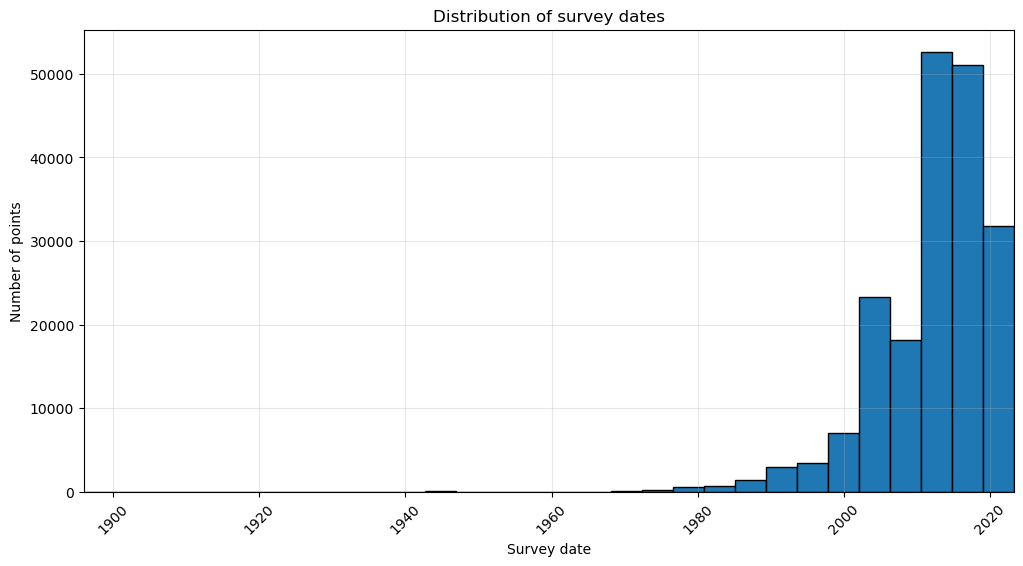

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf['SurveyDate'].hist(bins=30, edgecolor='black')

ax.set_title('Distribution of survey dates')
ax.set_xlabel('Survey date')
ax.set_ylabel('Number of points')
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3)
ax.set_xlim([gdf['SurveyDate'].min(), gdf['SurveyDate'].max()])

plt.show()
fig.savefig(os.path.join(FIGURES_DIR, 'survey_dates_hist'))

In [41]:
zostera_gdf = gdf[gdf["HabType"] == "Zostera beds"]
kelp_gdf = gdf[gdf["HabType"] == "Kelp forests"]

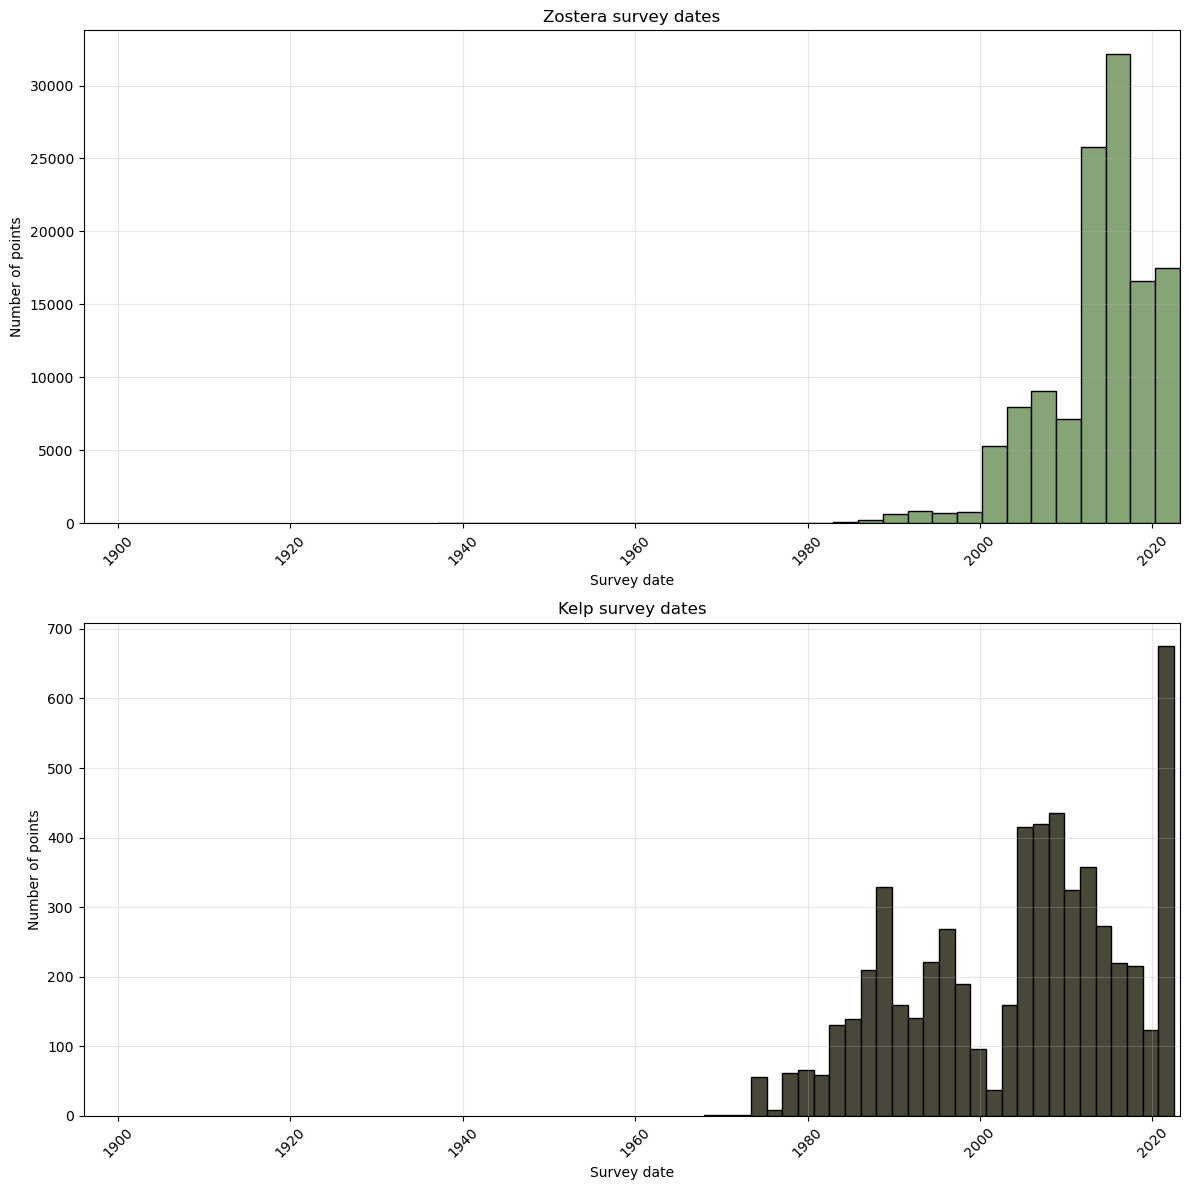

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

zostera_gdf['SurveyDate'].hist(bins=30, edgecolor='black', ax=axes[0], color='#86A475')
axes[0].set_title('Zostera survey dates')
axes[0].set_xlabel('Survey date')
axes[0].set_ylabel('Number of points')
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([gdf['SurveyDate'].min(), gdf['SurveyDate'].max()])

kelp_gdf['SurveyDate'].hist(bins=30, edgecolor='black', ax=axes[1], color='#494737')
axes[1].set_title('Kelp survey dates')
axes[1].set_xlabel('Survey date')
axes[1].set_ylabel('Number of points')
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([gdf['SurveyDate'].min(), gdf['SurveyDate'].max()])

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(FIGURES_DIR, 'survey_dates_zost_kelp'))

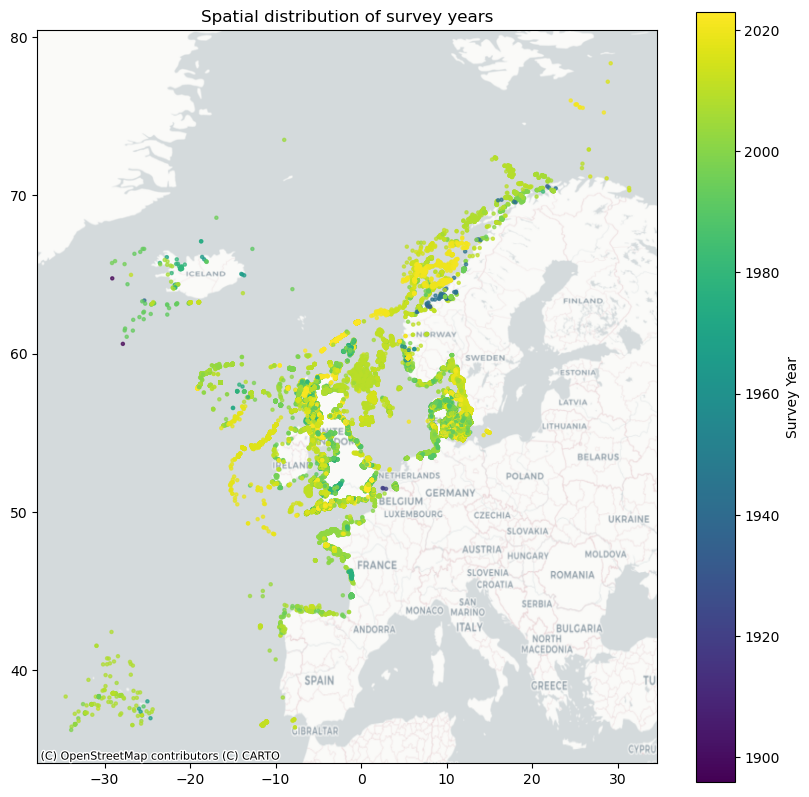

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column=gdf['SurveyYear'], cmap='viridis', markersize=5, alpha=0.7)
norm = Normalize(vmin=gdf['SurveyYear'].min(), vmax=gdf['SurveyYear'].max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Survey Year')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
ax.set_title('Spatial distribution of survey years')
plt.show()

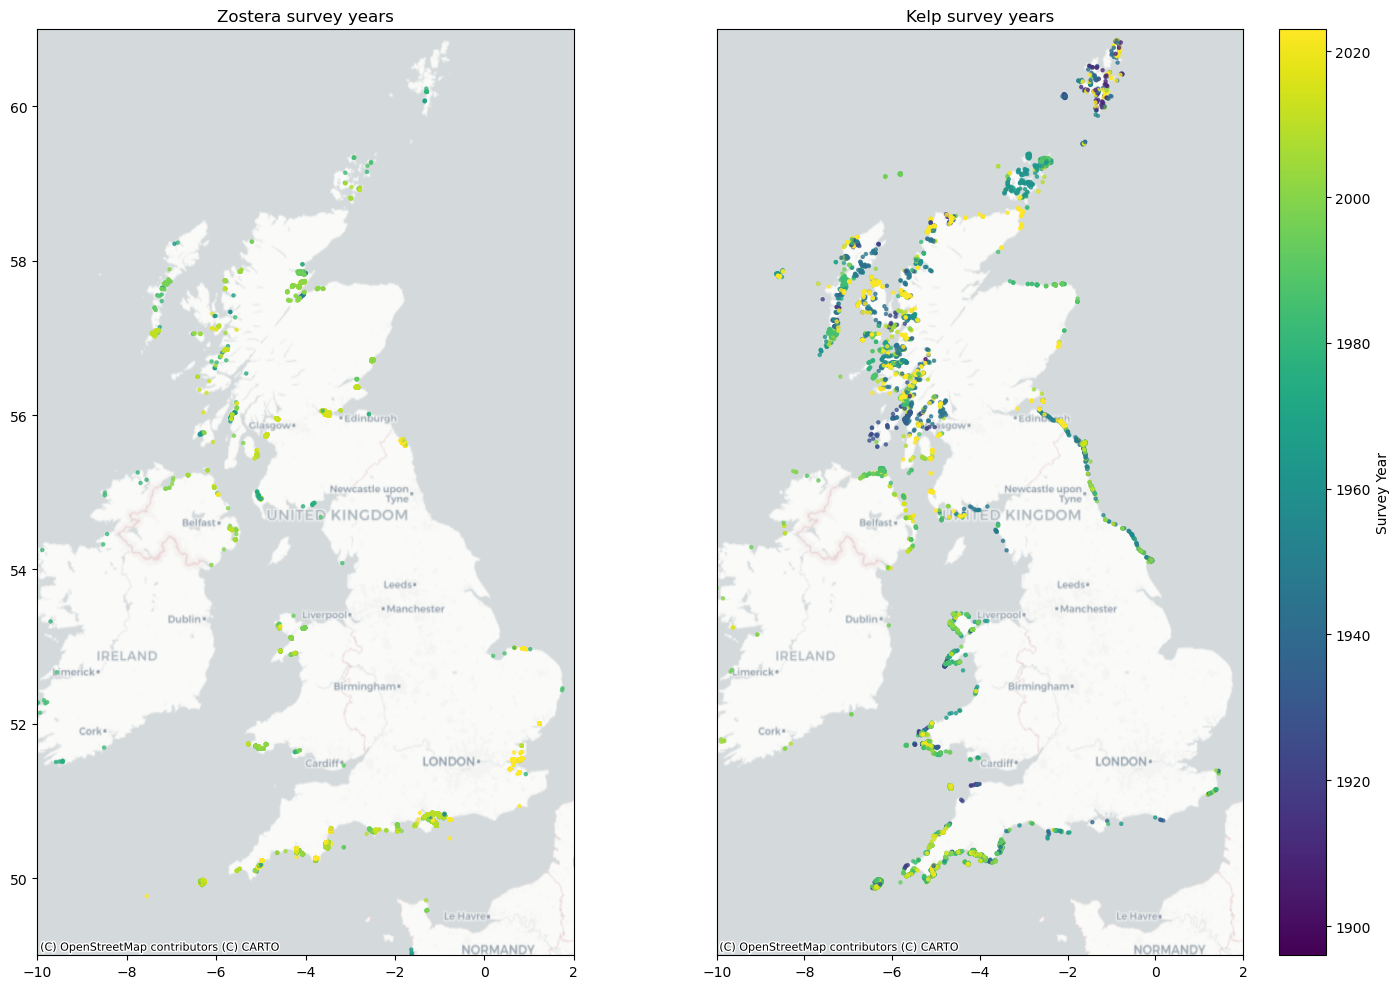

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

zostera_gdf.plot(ax=axes[0], column=zostera_gdf['SurveyYear'], cmap='viridis', markersize=5, alpha=0.7)
axes[0].set_title('Zostera survey years')
axes[0].set_xlim([-10, 2])
axes[0].set_ylim([49, 61])
cx.add_basemap(axes[0], crs=gdf.crs, source=cx.providers.CartoDB.Positron)

kelp_gdf.plot(ax=axes[1], column=kelp_gdf['SurveyYear'], cmap='viridis', markersize=5, alpha=0.7)
axes[1].set_title('Kelp survey years')
axes[1].set_yticks([])
axes[1].set_xlim([-10, 2])
axes[1].set_ylim([49, 61])
cx.add_basemap(axes[1], crs=gdf.crs, source=cx.providers.CartoDB.Positron)

norm = Normalize(vmin=gdf['SurveyYear'].min(), vmax=gdf['SurveyYear'].max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1])
cbar.set_label('Survey Year')

plt.tight_layout()
plt.show()

## Save results

In [51]:
gdf['SurveyDate'] = pd.to_datetime(gdf['SurveyDate']).dt.strftime('%Y-%m-%d')

In [52]:
save_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_mod/OSPAR2022Points.shp')

In [53]:
gdf.to_file(save_shp)